**Loading Dataset: (utomobile-customer-segmentation)**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/train_processed_data.csv')

In [ ]:
df.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


In [ ]:
y=df['Segmentation']
X = df.drop(columns=['Segmentation'])

In [ ]:
X = np.array(X)

### **SA-PSO-GK++ Approch**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score,calinski_harabasz_score


# === K-means++ SSE fitness function ===
def kmeans_sse(X, centroids):
    labels, _ = pairwise_distances_argmin_min(X, centroids)
    sse = sum(np.sum((X[labels == k] - centroids[k]) ** 2) for k in range(len(centroids)))
    return sse, labels

# === Gaussian Estimation of Distribution (GED) ===
def sample_from_ged(particles, K, n_features):
    flat_particles = np.array([p.flatten() for p in particles])  # shape (N, K*n_features)
    mean = np.mean(flat_particles, axis=0)
    std = np.std(flat_particles, axis=0) + 1e-6  # avoid zero std
    new_sample_flat = np.random.normal(loc=mean, scale=std)
    return new_sample_flat.reshape(K, n_features)

# === SA-PSO-GK++ Algorithm with dynamic inertia weight ===
def sa_pso_gkpp(X, K=4, N=50, max_iterations=100,
                w_max=0.9, w_min=0.5,
                c1=1.49, c2=1.49, T=100, alpha=0.95,seed=41):
    n_samples, n_features = X.shape


    kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10,random_state=seed)
    kmeans.fit(X)
    centroids = kmeans.cluster_centers_

    particles = [np.copy(centroids) for _ in range(N)]  # Initialize particles with KMeans++ centroids
    velocities = [np.zeros((K, n_features)) for _ in range(N)]

    particle_best = [np.copy(p) for p in particles]
    particle_best_fitness = [kmeans_sse(X, p)[0] for p in particles]

    # === Initialize global best ===
    global_best_index = np.argmin(particle_best_fitness)
    global_best = np.copy(particle_best[global_best_index])
    global_best_fitness = particle_best_fitness[global_best_index]

    for iteration in range(max_iterations):
        # Compute dynamic inertia weight
        w = w_max - ((w_max - w_min) * iteration / max_iterations)

        for i in range(N):
            current = particles[i]
            f_current, _ = kmeans_sse(X, current)

            # Update personal best
            if f_current < particle_best_fitness[i]:
                particle_best[i] = np.copy(current)
                particle_best_fitness[i] = f_current

            # Update global best
            if f_current < global_best_fitness:
                global_best = np.copy(current)
                global_best_fitness = f_current

            # Update velocity
            cognitive = c1 * np.random.rand() * (particle_best[i] - current)
            social = c2 * np.random.rand() * (global_best - current)
            velocities[i] = w * velocities[i] + cognitive + social

            # Update position using velocity
            new_position = current + velocities[i]

            # === GED: Gaussian Estimation of Distribution ===
            ged_position = sample_from_ged(particles, K, n_features)

            # Apply Simulated Annealing acceptance criterion
            f_ged, _ = kmeans_sse(X, ged_position)
            delta_f = f_ged - f_current

            if delta_f < 0 or np.random.rand() < np.exp(-delta_f / T):
                particles[i] = ged_position  # Accept new GED-sampled position
            else:
                particles[i] = new_position  # Accept updated velocity position

        T *= alpha  # Cool down temperature

    _, final_labels = kmeans_sse(X, global_best)
    return global_best, global_best_fitness, final_labels


**Run Algorithm for 100 iteration with number of particles 50 with  default (seed=41)**

In [ ]:
best_centroids, best_sse, predicted_labels = sa_pso_gkpp(
    X,
    K=y.nunique(),
    N=50,
    max_iterations=100,
    w_max=0.9,
    w_min=0.5,
    c1=1.49,
    c2=1.49,
    T=100,
    alpha=0.95
)


# Evaluate the result
print("(INteria) Best SSE:", best_sse)
print("Silhouette Score:", silhouette_score(X, predicted_labels))
sa_ch_score = calinski_harabasz_score(X, predicted_labels)
print("Calinski-Harabasz Score (SA-PSO-GK++):", sa_ch_score)


(INteria) Best SSE: 47030.616148285
Silhouette Score: 0.25772258536776227
Calinski-Harabasz Score (SA-PSO-GK++): 3267.7037926877415


**Runing 30 times with Different Random seeds**

In [ ]:
interia = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
sil_score = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
sa_ch_score = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}

In [ ]:
seeds= list(range(1,31))

for k in range(2,11,1):
  for i in range(30) :
        best_centroids, best_sse, predicted_labels = sa_pso_gkpp(
                        X,
                        K=k,
                        N=10,
                        max_iterations=100,
                        w_max=0.9,
                        w_min=0.5,
                        c1=1.49,
                        c2=1.49,
                        T=100,
                        alpha=0.95,
                        seed=seeds[i]
                    )
        # Evaluate the result
        interia[k].append(best_sse)
        sil_score[k].append(silhouette_score(X, predicted_labels))
        sa_ch_score[k].append(calinski_harabasz_score(X, predicted_labels))




**Validating Run variables**

In [ ]:
np.mean(interia[2])

np.float64(58011.99222669648)

In [ ]:
len(interia[10])

30

**Ploting inertia (SSE) over different number of clusters**

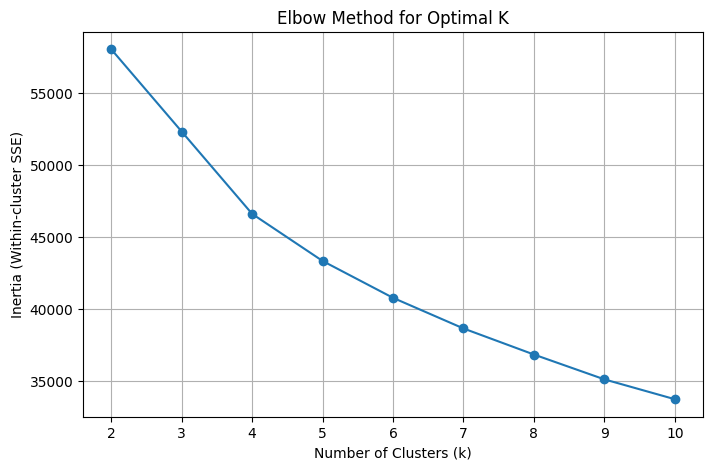

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np


inertias = []
K_range = range(2, 11)  # Try K from 1 to 10

for k in K_range:
    inertias.append(np.mean(interia[k]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.grid(True)
plt.show()


**loading Dataset: (mall-customer-segmentation)**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/processed_data.csv')
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


In [ ]:
X = df
X = np.array(X)

**Runing 30 times with Different Random seeds**

In [ ]:
interia = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
sil_score = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
sa_ch_score = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}

In [ ]:
seeds= list(range(1,31))

for k in range(2,11,1):
  for i in range(30) :
        best_centroids, best_sse, predicted_labels = sa_pso_gkpp(
                        X,
                        K=k,
                        N=10,
                        max_iterations=100,
                        w_max=0.9,
                        w_min=0.5,
                        c1=1.49,
                        c2=1.49,
                        T=100,
                        alpha=0.95,
                        seed=seeds[i]
                    )
        # Evaluate the result
        interia[k].append(best_sse)
        sil_score[k].append(silhouette_score(X, predicted_labels))
        sa_ch_score[k].append(calinski_harabasz_score(X, predicted_labels))


**Ploting inertia (SSE) over different number of clusters**

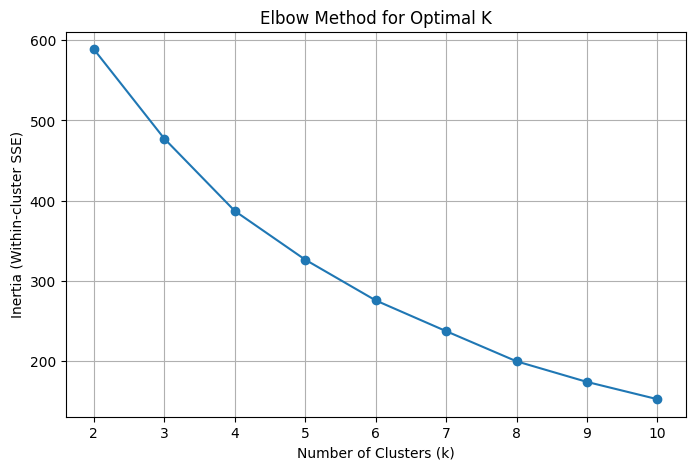

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np


inertias = []
K_range = range(2, 11)  # Try K from 1 to 10

for k in K_range:
    inertias.append(np.mean(interia[k]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.grid(True)
plt.show()


**Saving Scores**

In [ ]:
import json


# Combine into one dict
results = {
    "inertia": interia,
    "silhouette_score": sil_score,
    "calinski_harabasz_score": sa_ch_score,
    "inertias": inertias

}

# Save to JSON file
with open("clustering_scores.json", "w") as f:
    json.dump(results, f, indent=4)

In [33]:
import json

with open('/content/Dataset1.json', 'r') as f:
    json_data = json.load(f)

print(json_data)


{'inertia': {'1': [], '2': [588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938, 588.8026767824938], '3': [476.787554413516, 476.7875544135159, 476.787554413516, 476.7732065607644, 476.7732065607644, 476.787554413516, 476.7732065607643, 476.86006878694366, 476.787554413516, 476.7875544135159, 476.787554413516, 476.7875544135159, 476.787554413516, 476.7732065607644, 476.7732065607644, 476.787554413516, 476.7732065607643, 476.7875544135159, 476.787554413516, 476.787554413516, 476.86006878694366, 484

In [34]:
import pandas as pd
import numpy as np
# Flatten the data
records = []

for k in range(2,11,1):
    inertia_vals = np.mean(json_data['inertia'][str(k)])
    sil_vals = np.mean(json_data["silhouette_score"][str(k)])
    ch_vals = np.mean(json_data["calinski_harabasz_score"][str(k)])


    records.append({
            "K": int(k),
            "inertia": inertia_vals,
            "silhouette": sil_vals,
            "calinski_harabasz": ch_vals
        })

# Create DataFrame
df = pd.DataFrame(records)
print(df.head(10))

    K     inertia  silhouette  calinski_harabasz
0   2  588.802677    0.251815          71.020516
1   3  477.415871    0.259471          66.559230
2   4  387.283549    0.300851          69.624552
3   5  326.536149    0.315421          70.690124
4   6  275.775276    0.330852          73.756771
5   7  237.453683    0.357257          76.213211
6   8  199.848291    0.387807          82.369096
7   9  174.161839    0.402511          85.793117
8  10  152.618683    0.419530          89.565182


In [35]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

metrics = ['inertia', 'silhouette', 'calinski_harabasz']
df_scaled = df.copy()

# Inertia should be minimized, so we invert it after scaling
scaler = MinMaxScaler()

# Scale silhouette and Calinski-Harabasz (want to maximize)
df_scaled[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(df[['silhouette', 'calinski_harabasz']])

# Scale inertia (then invert to convert into a maximization metric)
df_scaled['inertia'] = 1 - scaler.fit_transform(df[['inertia']])

In [36]:
df_scaled

,K,inertia,silhouette,calinski_harabasz
0,2,0.000000,0.000000,0.193919
1,3,0.255367,0.045650,0.000000
2,4,0.462005,0.292376,0.133240
3,5,0.601275,0.379249,0.179558
4,6,0.717650,0.471256,0.312856
5,7,0.805506,0.628694,0.419630
6,8,0.891721,0.810854,0.687208
7,9,0.950610,0.898521,0.836040
8,10,1.000000,1.000000,1.000000


In [37]:
df_scaled['composite_score'] = (
    0.4 * df_scaled['inertia'] +
    0.2 * df_scaled['silhouette'] +
    0.4 * df_scaled['calinski_harabasz']
)
df_scaled.style.highlight_max(color='lightgreen', subset=['composite_score'])

,K,inertia,silhouette,calinski_harabasz,composite_score
0,2,0.000000,0.000000,0.193919,0.077568
1,3,0.255367,0.045650,0.000000,0.111277
2,4,0.462005,0.292376,0.133240,0.296573
3,5,0.601275,0.379249,0.179558,0.388183
4,6,0.717650,0.471256,0.312856,0.506453
5,7,0.805506,0.628694,0.419630,0.615793
6,8,0.891721,0.810854,0.687208,0.793742
7,9,0.950610,0.898521,0.836040,0.894364
8,10,1.000000,1.000000,1.000000,1.000000


,K,inertia,silhouette,calinski_harabasz,composite_score
8,10,1.0,1.0,1.0,1.0


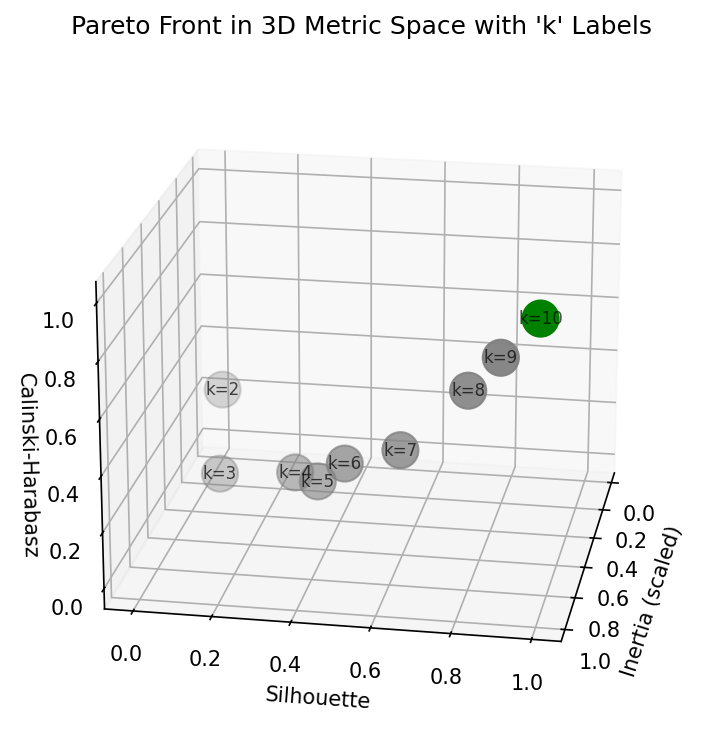

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Copy the scaled dataframe
df = df_scaled.copy()

# Select metrics to include in Pareto optimization (assumed scaled)
metrics = ['inertia', 'silhouette', 'calinski_harabasz']
data = df[metrics].values

# Pareto front function
def is_pareto_efficient(data):
    is_efficient = np.ones(data.shape[0], dtype=bool)
    for i, point in enumerate(data):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(data[is_efficient] > point, axis=1) | np.all(data[is_efficient] == point, axis=1)
            is_efficient[i] = True
    return is_efficient

# Apply Pareto front logic
df['pareto_optimal'] = is_pareto_efficient(data)

# Display Pareto-optimal rows
pareto_df = df[df['pareto_optimal']]
display(pareto_df[['K', 'inertia', 'silhouette', 'calinski_harabasz', 'composite_score']])



# 3D Visualization with 'k' labels
fig = plt.figure(figsize=(6, 6), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on Pareto optimality
ax.scatter(df['inertia'], df['silhouette'], df['calinski_harabasz'],
           c=df['pareto_optimal'].map({True: 'green', False: 'gray'}), s=300)

# Add 'k' labels to each point
for _, row in df.iterrows():
    ax.text(row['inertia'], row['silhouette'], row['calinski_harabasz'],
            f"k={row['K']}", fontsize=8, alpha=0.7,
            color='black', ha='center', va='center')

# Axis labels and title
ax.view_init(elev=20, azim=10)
ax.set_xlabel("Inertia (scaled)")
ax.set_ylabel("Silhouette")
ax.set_zlabel("Calinski-Harabasz", labelpad=1)
plt.title("Pareto Front in 3D Metric Space with 'k' Labels")
plt.show()